# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow import keras
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from skimage.transform import resize
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras import layers
! pip install visualkeras
import visualkeras
import os

import warnings
warnings.filterwarnings('ignore')

2023-04-03 11:40:51.470344: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load Dataset & Perform EDA

In [32]:
dir = '.'
label = []
path = []
for dirname, _,filenames in os.walk(dir):
    for filename in filenames:
        label.append(os.path.split(dirname)[1])
        path.append(os.path.join(dirname,filename))
             
df = pd.DataFrame(columns=['Image','Label'])
df['Image']=path
df['Label']=label

df = shuffle(df)
df = df.reset_index(drop=True)
df

,Image,Label
0,./images/maleeyes/4303.jpg,maleeyes
1,./images/maleeyes/1608.jpg,maleeyes
2,./images/femaleeyes/5038.jpg,femaleeyes
3,./images/femaleeyes/3531.jpg,femaleeyes
4,./images/maleeyes/4230.jpg,maleeyes
...,...,...
10004,./images/femaleeyes/5698.jpg,femaleeyes
10005,./images/maleeyes/51.jpg,maleeyes
10006,./images/maleeyes/6704.jpg,maleeyes
10007,./images/maleeyes/2443.jpg,maleeyes


### Observing Dataset

In [33]:
# Total number of samples
len(df)

10009

In [34]:
# Check first 5 rows
df.head()

,Image,Label
0,./images/maleeyes/4303.jpg,maleeyes
1,./images/maleeyes/1608.jpg,maleeyes
2,./images/femaleeyes/5038.jpg,femaleeyes
3,./images/femaleeyes/3531.jpg,femaleeyes
4,./images/maleeyes/4230.jpg,maleeyes


In [35]:
# Check last 5 columns
df.tail()

,Image,Label
10004,./images/femaleeyes/5698.jpg,femaleeyes
10005,./images/maleeyes/51.jpg,maleeyes
10006,./images/maleeyes/6704.jpg,maleeyes
10007,./images/maleeyes/2443.jpg,maleeyes
10008,./images/femaleeyes/4652.jpg,femaleeyes


In [36]:
# Column info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10009 entries, 0 to 10008
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   10009 non-null  object
 1   Label   10009 non-null  object
dtypes: object(2)
memory usage: 156.5+ KB


In [37]:
# check total count and frequency of each label
df.describe()

,Image,Label
count,10009,10009
unique,10009,5
top,./images/maleeyes/4303.jpg,maleeyes
freq,1,6323


There are total of 11525 Images in the entire dataset, having 2 labels [maleeyes, femaleeyes]. Frequency of maleeyes is greater then frequency of female eyes.

In [38]:
# check for null values or missing labels
df.isna().sum()

Image    0
Label    0
dtype: int64

No null entries present in dataset.

In [39]:
# check for duplicate entries
df.duplicated().any()

False

All the samples in the dataset are unique

maleeyes              6323
femaleeyes            3678
.                        5
.ipynb_checkpoints       2
images                   1
Name: Label, dtype: int64


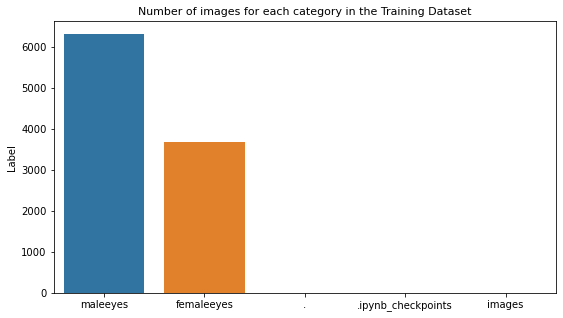

In [41]:
# Count number of samples for each category [Male, Female]
vc = df['Label'].value_counts()
print(vc)

plt.figure(figsize = (9, 5))
sns.barplot(x = vc.index, y = vc)
plt.title("Number of images for each category in the Training Dataset", fontsize = 11)
plt.show()

The dataset has 6323 images of male and 5202 images of female eyes

#### Balancing Dataset

In [43]:
# Using downsampling to balance the dataset, 
# as there is not a big difference in the total number of samples in both categories

# Dividing majority and minority classes
df_major = df[df.Label=='maleeyes']
df_minor = df[df.Label=='femaleeyes']

df_major_sample = resample(df_major,
                           replace=True,  # Down sample without replacement
                           n_samples=5202,   # Number to match minority class
                           random_state=42,
                          )
  
# Combine both samples
df = pd.concat([df_major_sample, df_minor])
df = shuffle(df)
df = df.reset_index(drop=True)

# Display count of data points in both class
print(df.Label.value_counts())

df.describe()

maleeyes      5202
femaleeyes    3678
Name: Label, dtype: int64


,Image,Label
count,8880,8880
unique,7166,2
top,./images/maleeyes/4281.jpg,maleeyes
freq,7,5202


Using the downsampling technique we removed extra samples from maleeyes, now both labels have 5202 samples having all unique values. 

### Observing the images

Here we can see that size of both images are not same, hence we will resize female images to 54x54

In [44]:
# Get index of male and female eye
xx = df[df['Label'] == 'femaleeyes'].index[0] # index of female eye
xy = df[df['Label'] == 'maleeyes'].index[0] # index of male eye

Text(0.5, 1.0, 'femaleeyes')

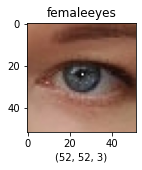

In [45]:
# visualize female eye
figure = plt.figure(figsize=(2,2))
x = plt.imread(df["Image"][xx])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(df["Label"][xx])

Text(0.5, 1.0, 'maleeyes')

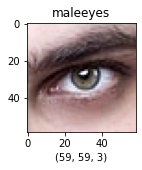

In [46]:
# visualize male eye
figure = plt.figure(figsize=(2, 2))
x = plt.imread(df["Image"][xy])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(df["Label"][xy])

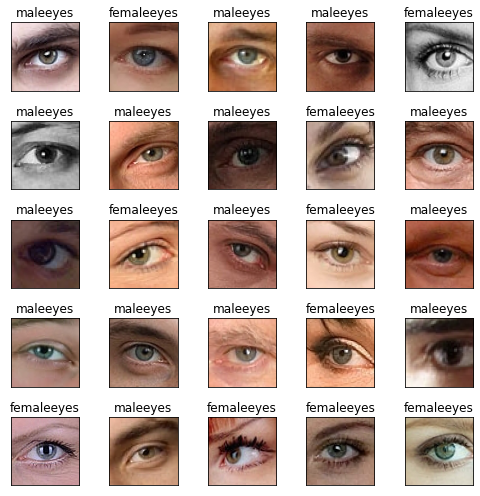

In [47]:
# plot more random images from dataset
fig, axes = plt.subplots(nrows = 5,
                        ncols = 5,
                        figsize = (7, 7),
                        subplot_kw = {"xticks":[],"yticks":[]})

for i,ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df["Image"][i]))
    ax.set_title(df["Label"][i])
plt.tight_layout()
plt.show()

In [48]:
# Checking image size
female_eye_size = plt.imread(df["Image"][xx])
print(female_eye_size.shape, '==>',  df['Label'][xx])

male_eye_size = plt.imread(df["Image"][xy])
print(male_eye_size.shape, '==>',  df['Label'][xy])

(52, 52, 3) ==> femaleeyes
(59, 59, 3) ==> maleeyes


Here all the images have varying sizes, we should resize all the images to equal size for better classification.

In [49]:
# Check how many different sized images are there

size_list=set() # empty set for checking total different sizes of images

for x in range(len(df['Image'])):
    size_list.add(plt.imread(df["Image"][x]).shape)

print(len(size_list))
print('Smallest size :', list(sorted(size_list))[0])
print('Largest size :', list(sorted(size_list))[-1])

60
Smallest size : (41, 41, 3)
Largest size : (113, 113, 3)


The dataset contains images with 65 different sizes, ranging from 41x41 to 117x117.
We will now resize them to 64x64 size.

In [50]:
# Convert image path to array of image using cv2
size = (64,64)
df1 = df.copy()

size_list = set()
for i in range(len(df)):
    image=cv2.imread(df['Image'][i])
    image=cv2.resize(image,size)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    size_list.add(image.shape)
    df1['Image'][i] = image.flatten()

In [51]:
# Check shape after resizing
size_list

{(64, 64, 3)}

Now all the images have same size ==> 64x64, and falttened to perform KNN

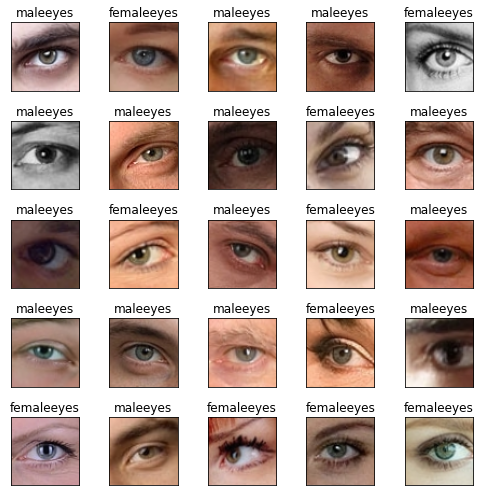

In [52]:
# Finally let's see some random images again

fig, axes = plt.subplots(nrows = 5,
                        ncols = 5,
                        figsize = (7, 7),
                        subplot_kw = {"xticks":[],"yticks":[]})

for i,ax in enumerate(axes.flat):
    ax.imshow(df1.Image[i].reshape(64,64,3))
    ax.set_title(df1["Label"][i])
plt.tight_layout()
plt.show()

In [53]:
# Convert labels to numeric values

LE = LabelEncoder()

df1['Label'] = np.asarray(LE.fit_transform(df1["Label"]))

display(df1.head())

,Image,Label
0,"[250, 234, 234, 249, 233, 233, 251, 234, 234, ...",1
1,"[184, 133, 106, 182, 131, 105, 181, 130, 104, ...",0
2,"[228, 179, 139, 227, 178, 137, 227, 179, 140, ...",1
3,"[176, 126, 103, 173, 123, 100, 171, 119, 95, 1...",1
4,"[112, 112, 112, 112, 112, 112, 89, 89, 89, 114...",0


# KNN

In [54]:
# Function to reset the index and reshape the array 
def cleaned(X):
    for i in range(len(X)):
        X[i] = np.vstack(X[i].reset_index(drop=True))
    return X

In [55]:
# Split data into train and test
X_train1, X_test1,y_train1, y_test1 = train_test_split(df1.Image, df1.Label, test_size = 0.2, random_state = 7)

X_train1, X_test1,y_train1, y_test1 = cleaned([X_train1, X_test1,y_train1, y_test1])

print(X_train1.shape, X_test1.shape)
print(y_train1.shape, y_test1.shape)


(7104, 12288) (1776, 12288)
(7104, 1) (1776, 1)


In [60]:
# Applying KNN multiple times to find best value of K

error_rate = []
acc = []

for i in range(1,5):
 
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train1,y_train1)
    pred_i = knn.predict(X_test1)
    error_rate.append(np.mean(pred_i != y_test1))

Text(0, 0.5, 'Error Rate')

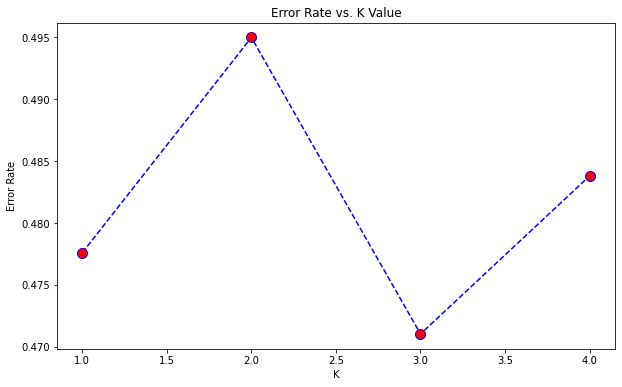

In [61]:
# Elbow plot to see optimum value of K
plt.figure(figsize=(10,6))
plt.plot(range(1,5),error_rate,color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [62]:
# NOW WITH K=16
KNN = KNeighborsClassifier(n_neighbors=20)
KNN.fit(X_train1,y_train1)
knn_pred = KNN.predict(X_test1)

In [63]:
# Print accuracy
%time
# 84.1 - Best Accuracy found 
print('KNN Accuracy: %.3f' % accuracy_score(y_test1,knn_pred))

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 13.1 µs
KNN Accuracy: 0.835


Text(0.5, 1.0, 'Accuracy Score: 0.8350225225225225')

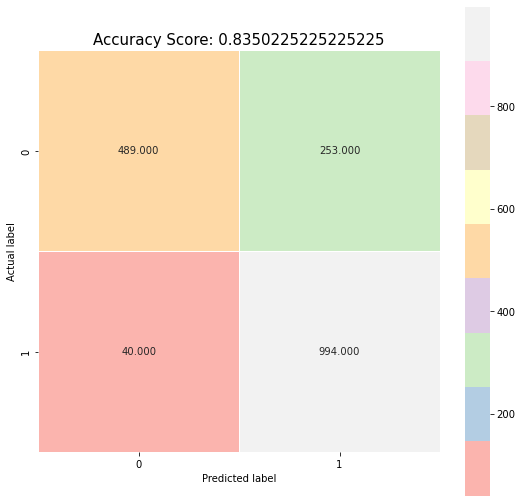

In [64]:
# Confusion Matrix
knn_cm = confusion_matrix(y_test1,knn_pred)
plt.figure(figsize=(9,9))
sns.heatmap(knn_cm,annot=True, fmt='.3f', linewidths=.5, square=True,cmap="Pastel1")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test1,knn_pred))
plt.title(all_sample_title,size=15)

In [65]:
# Classification report
KNN_Classification_Report = classification_report(y_test1,knn_pred)
print(KNN_Classification_Report)

              precision    recall  f1-score   support

           0       0.92      0.66      0.77       742
           1       0.80      0.96      0.87      1034

    accuracy                           0.84      1776
   macro avg       0.86      0.81      0.82      1776
weighted avg       0.85      0.84      0.83      1776



We can see from the confusion matrix that our KNN classifier has an accuracy of approx 83.7%, where from 2081 samples, the algorithm correctly identified 840 samples as True Positive, 901 as True Negatives, 193 as False Positive and 147 as False Negatives.

With an average precision of 84%, recall of 84% and f1-score and accuracy of about 0.84. 

# MLP


#### Train Val Test Split

In [66]:
# Deviding df to Train Test and Validation set

X_train2, X_val2, y_train2, y_val2 = train_test_split(df1.Image, df1.Label, test_size = 0.4, random_state = 7)
X_val2, X_test2,y_val2, y_test2 = train_test_split(X_val2, y_val2, test_size = 0.5, random_state = 7)

x_train2, x_val2, x_test2, y_train2, y_val2, y_test2 = cleaned([X_train2, X_val2, X_test2, y_train2, y_val2, y_test2])

print("X_Train: ", x_train2.shape) 
print("X_Val: ", x_val2.shape) 
print("X_Test: ", x_test2.shape) 
print("y_Train: ", y_train2.shape) 
print("y_Val: ", y_val2.shape) 
print("y_test: ", y_test2.shape) 

X_Train:  (5328, 12288)
X_Val:  (1776, 12288)
X_Test:  (1776, 12288)
y_Train:  (5328, 1)
y_Val:  (1776, 1)
y_test:  (1776, 1)


#### Model Architechture

In [67]:
# Model architechture
MLP = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1024, activation=tf.nn.leaky_relu), 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation=tf.nn.leaky_relu), 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid') 
])

2023-04-03 12:29:52.769540: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Optimize

In [68]:
male = len(y_train2[y_train2>0])
female = len(y_train2) - male
total = len(y_train2)
weight_for_male = total / (2 * male) 
weight_for_female = total / (2 * female)
class_weight = {0: weight_for_female, 1: weight_for_male}
print(class_weight)

# Optimizer
adam_optimizer = tf.keras.optimizers.Adam()

{0: 1.2293493308721735, 1: 0.8427712749130022}


#### Compile

In [69]:

MLP.compile(
    optimizer=adam_optimizer,
    loss='binary_crossentropy',
    metrics=[
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
    ]
)


#### Training model

In [70]:
# Training 
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train2)
mlp_history = MLP.fit(x_train_scaled, 
          y_train2,
          class_weight=class_weight,
          batch_size=64,
          validation_data=(x_val2,y_val2),
#           callbacks=[save_best_callback],
          epochs=20)

Epoch 1/20
84/84 [==============================] - 6s 56ms/step - loss: 7.1846 - tp: 2183.0000 - fp: 704.0000 - tn: 1463.0000 - fn: 978.0000 - accuracy: 0.6843 - precision: 0.7561 - recall: 0.6906 - auc: 0.7061 - val_loss: 212.6867 - val_tp: 535.0000 - val_fp: 36.0000 - val_tn: 702.0000 - val_fn: 503.0000 - val_accuracy: 0.6965 - val_precision: 0.9370 - val_recall: 0.5154 - val_auc: 0.7342
Epoch 2/20
84/84 [==============================] - 4s 49ms/step - loss: 4.3763 - tp: 2408.0000 - fp: 521.0000 - tn: 1646.0000 - fn: 753.0000 - accuracy: 0.7609 - precision: 0.8221 - recall: 0.7618 - auc: 0.7907 - val_loss: 454.8368 - val_tp: 169.0000 - val_fp: 6.0000 - val_tn: 732.0000 - val_fn: 869.0000 - val_accuracy: 0.5073 - val_precision: 0.9657 - val_recall: 0.1628 - val_auc: 0.5783
Epoch 3/20
84/84 [==============================] - 4s 48ms/step - loss: 2.7201 - tp: 2468.0000 - fp: 478.0000 - tn: 1689.0000 - fn: 693.0000 - accuracy: 0.7802 - precision: 0.8377 - recall: 0.7808 - auc: 0.8196 -

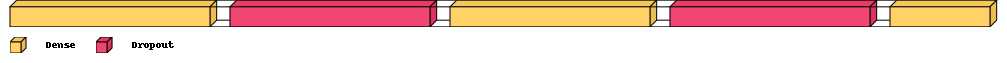

In [71]:
print()
visualkeras.layered_view(MLP, scale_xy=100, scale_z=100, max_z=200, legend = True, spacing = 20)

#### Evaluate & Predict

In [72]:
# Evaluate model
x_test_scaled = scaler.fit_transform(x_test2)
score = MLP.evaluate(x_test_scaled, y_test2, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.3004078269004822
Test accuracy: 973.0


In [73]:
# Predictions 
y_pred2 = MLP.predict(x_test_scaled)
y_pred2 = np.where(y_pred2 > 0.5, 1, 0)
y_pred2

56/56 [==============================] - 0s 8ms/step


array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

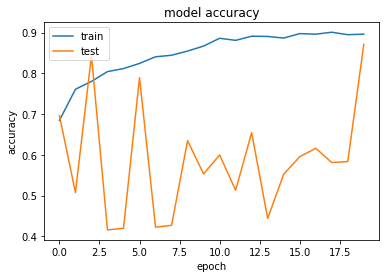

In [74]:
# summarize history for accuracy
plt.plot(mlp_history.history['accuracy'])
plt.plot(mlp_history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('model accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

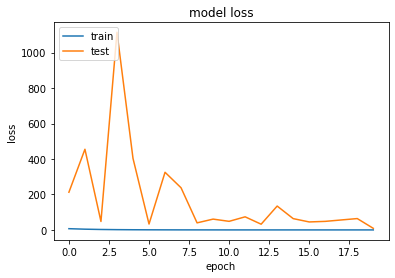

In [75]:
# summarize history for loss
plt.plot(mlp_history.history['loss'])
plt.plot(mlp_history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [76]:
# Classification report
MLP_Classification_Report = classification_report(y_test2,y_pred2)
print(MLP_Classification_Report)

              precision    recall  f1-score   support

           0       0.95      0.76      0.85       773
           1       0.84      0.97      0.90      1003

    accuracy                           0.88      1776
   macro avg       0.90      0.87      0.87      1776
weighted avg       0.89      0.88      0.88      1776



# CNN

#### Helper Functions

In [91]:
# Helper function
def to_tensor(_list):
    LIST = []
    for i in range(len(_list)):
        print(_list[i].shape, type(_list[i]))
        print(tf.convert_to_tensor(_list[i]).shape, type(tf.convert_to_tensor(_list[i])))
        LIST.append(tf.convert_to_tensor(_list[i]))
    return LIST

In [99]:
# Helper function
# Function to reset the index and reshape the array 
def cleaned2(X):
    for i in range(len(X)):
        print(type(X[i]), X[i].values.shape, np.stack(X[i].reset_index(drop=True)).shape)
        X[i] = np.stack(X[i].reset_index(drop=True))
    return X

In [79]:
# Convert image path to array of image using cv2
size = (64,64)
df2 = df.copy()

for i in range(len(df)):
    image=cv2.imread(df['Image'][i])
    image=cv2.resize(image,size)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    df2['Image'][i] = image
    
# Convert labels to numeric values

LE = LabelEncoder()

df2['Label'] = np.asarray(LE.fit_transform(df2["Label"]))

display(df2.head())

,Image,Label
0,"[[[250, 234, 234], [249, 233, 233], [251, 234,...",1
1,"[[[184, 133, 106], [182, 131, 105], [181, 130,...",0
2,"[[[228, 179, 139], [227, 178, 137], [227, 179,...",1
3,"[[[176, 126, 103], [173, 123, 100], [171, 119,...",1
4,"[[[112, 112, 112], [112, 112, 112], [89, 89, 8...",0


In [80]:
df2.Image[1].shape

(64, 64, 3)

In [100]:
# Deviding df to Train Test and Validation set

x_train3, x_val3, y_train3, y_val3 = train_test_split(df2.Image, df2.Label, test_size = 0.4, random_state = 7)
x_val3, x_test3, y_val3, y_test3 = train_test_split(x_val3, y_val3, test_size = 0.5, random_state = 7)

x_train3, x_val3, x_test3, y_train3, y_val3, y_test3 = cleaned2([x_train3, x_val3, x_test3, y_train3, y_val3, y_test3])
x_train3, x_val3, x_test3, y_train3, y_val3, y_test3 = to_tensor([x_train3, x_val3, x_test3, y_train3, y_val3, y_test3])

print("X Train: ", x_train3.shape) 
print("X Val: ", x_val3.shape) 
print("X Test: ", x_test3.shape) 
print("y Train: ", y_train3.shape) 
print("y Val: ", y_val3.shape) 
print("y test: ", y_test3.shape) 
print(type(x_train3))

<class 'pandas.core.series.Series'> (5328,) (5328, 64, 64, 3)
<class 'pandas.core.series.Series'> (1776,) (1776, 64, 64, 3)
<class 'pandas.core.series.Series'> (1776,) (1776, 64, 64, 3)
<class 'pandas.core.series.Series'> (5328,) (5328,)
<class 'pandas.core.series.Series'> (1776,) (1776,)
<class 'pandas.core.series.Series'> (1776,) (1776,)
(5328, 64, 64, 3) <class 'numpy.ndarray'>
(5328, 64, 64, 3) <class 'tensorflow.python.framework.ops.EagerTensor'>
(1776, 64, 64, 3) <class 'numpy.ndarray'>
(1776, 64, 64, 3) <class 'tensorflow.python.framework.ops.EagerTensor'>
(1776, 64, 64, 3) <class 'numpy.ndarray'>
(1776, 64, 64, 3) <class 'tensorflow.python.framework.ops.EagerTensor'>
(5328,) <class 'numpy.ndarray'>
(5328,) <class 'tensorflow.python.framework.ops.EagerTensor'>
(1776,) <class 'numpy.ndarray'>
(1776,) <class 'tensorflow.python.framework.ops.EagerTensor'>
(1776,) <class 'numpy.ndarray'>
(1776,) <class 'tensorflow.python.framework.ops.EagerTensor'>
X Train:  (5328, 64, 64, 3)
X Val:

#### Model Architechture

In [101]:
# Alex-Net Architechture

CNN=keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(64,64,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(1,activation='sigmoid')  
])

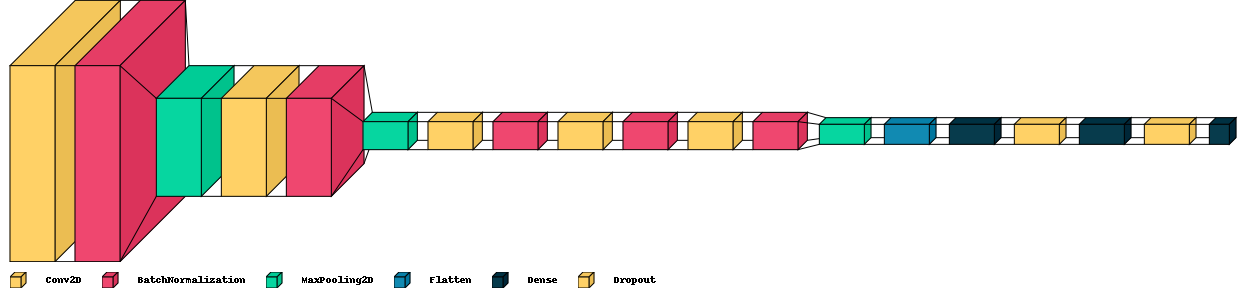

In [102]:
print()
visualkeras.layered_view(CNN, scale_xy=14, scale_z=14, max_z=45, legend = True, spacing = 20)

In [103]:
CNN.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [104]:
x_train3.shape

TensorShape([5328, 64, 64, 3])

In [105]:
cnn_history=CNN.fit(x_train3, y_train3, validation_data=(x_val3, y_val3),
            epochs=20,
#             callbacks=[early_stop,reduce_lr]
           )

Epoch 1/20
167/167 [==============================] - 11s 59ms/step - loss: 0.6348 - accuracy: 0.7151 - val_loss: 0.5768 - val_accuracy: 0.7264
Epoch 2/20
167/167 [==============================] - 10s 61ms/step - loss: 0.3856 - accuracy: 0.8367 - val_loss: 0.3074 - val_accuracy: 0.8812
Epoch 3/20
167/167 [==============================] - 11s 66ms/step - loss: 0.3240 - accuracy: 0.8688 - val_loss: 0.4345 - val_accuracy: 0.7703
Epoch 4/20
167/167 [==============================] - 11s 63ms/step - loss: 0.2850 - accuracy: 0.8902 - val_loss: 0.4758 - val_accuracy: 0.8204
Epoch 5/20
167/167 [==============================] - 11s 64ms/step - loss: 0.2657 - accuracy: 0.8966 - val_loss: 0.2385 - val_accuracy: 0.9043
Epoch 6/20
167/167 [==============================] - 11s 68ms/step - loss: 0.2319 - accuracy: 0.9170 - val_loss: 0.3290 - val_accuracy: 0.8530
Epoch 7/20
167/167 [==============================] - 11s 66ms/step - loss: 0.2093 - accuracy: 0.9242 - val_loss: 0.2977 - val_accuracy:

#### Plot Training and Validation Loss 

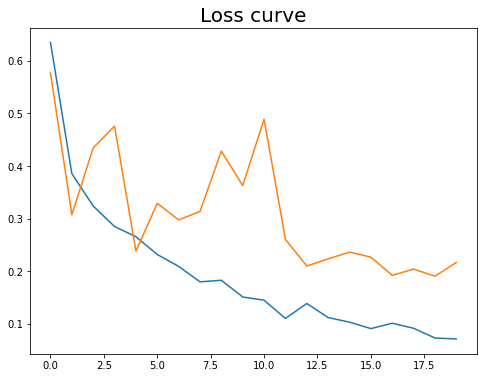

In [106]:
plt.figure(figsize=(8,6))
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('Loss curve',fontdict={'size':20})
plt.show()


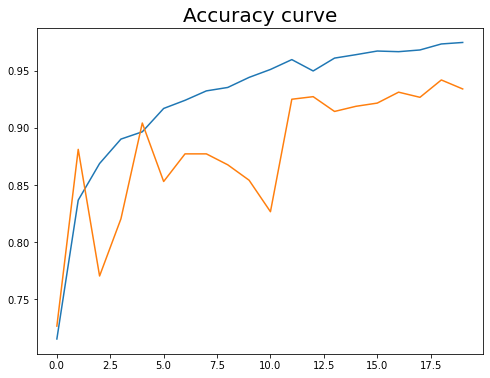

In [107]:
plt.figure(figsize=(8,6))
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('Accuracy curve',fontdict={'size':20})
plt.show()

In [110]:
y_pred_CNN = CNN.predict(x_test3)
y_pred_CNN = np.round(y_pred_CNN)

recall_CNN = recall_score(y_test3, y_pred_CNN)
precision_CNN = precision_score(y_test3, y_pred_CNN)
f1_CNN = f1_score(y_test3, y_pred_CNN)
roc_CNN = roc_auc_score(y_test3, y_pred_CNN)

56/56 [==============================] - 1s 16ms/step


In [112]:
# Classification report
CNN_Classification_Report = classification_report(y_test3, y_pred_CNN)
print(CNN_Classification_Report)

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       773
           1       0.94      0.94      0.94      1003

    accuracy                           0.93      1776
   macro avg       0.93      0.93      0.93      1776
weighted avg       0.93      0.93      0.93      1776

